In [1]:
try:
    import fb2
    print("Already installed")
except ImportError:
    %pip install -q "fb2 @ git+https://github.com/Mads-PeterVC/fb2.git" # Install from GitHub.
    print("Installed fb2 from GitHub")

Already installed


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from fb2 import mm_widget, add_textbox, get_mm_dataset_path, get_quiz

# Michaelis-Menten Kinetik

Som beskrevet tidligere i kurset kan nogle enzyme katalyserede reaktioner beskrives med **Michaelis-Menten ligningen**:

$$
v = \frac{V_{\mathrm{max}}[S]}{K_m + [S]}
$$

Hvor 

- $v$ er reaktions hastigheden.
- $[S]$ er koncentrationen af substratet. 
- $V_{\mathrm{max}}$ er den maksimale reaktions rate. 
- $K_m$ er Michaelis konstanten

Vi vil i disse opgaver analysere Michaelis-Menten ligningen og bruge den til at fitte data 
om en enzyme katalyseret reaktion.

### Opgave 1: Analyse af Michaelis-Menten ligningen

Cellen nedenfor laver et interaktivt plot af Michaelis-Menten ligningen, brug 
dette til at svare på disse spørgsmål: 

- Hvad er betydningen af $V_\mathrm{max}$? Hvilken indflydelse har denne parametre? 
- Hvad kontrollere $K_m$ parameteren? Hvad sker der hvis $K_m$ er lille/stor? 
- Hvad er værdien af reaktions hastigheden når substrat koncentrationen er lig $K_m$?
- Hvorfor er det en asymptoptisk kurve? Hvad betyder det for enzymerne i reaktionen?

Snak gerne om spørgsmålene i små grupper.

In [3]:
mm_widget()

### Datasæt

Vi vil i resten af opgaven lære at bruge Python til at fitte Michaelis-Menten ligningen mod data, så 
de to parametre kan findes. 

Til dette vil vi bruge data'en vist nedenfor

In [4]:
# path = get_mm_dataset_path()  # Henter stien til mm_data.txt - Hvis Colab / Data fra GitHub.
path = 'combined_data.txt'
data = pd.read_csv(path, sep='\t') # Læser data fra en tab-separeret fil
data # Udskriver data for at se hvad der er i filen - Pænt i Jupyter Notebook.

,Substrate_Concentration,Reaction_Velocity,Inverse_Substrate,Inverse_Velocity
0,0.1,0.238095,10.0,4.20
1,0.2,0.454545,5.0,2.20
2,0.5,1.000000,2.0,1.00
3,1.0,1.666667,1.0,0.60
4,2.0,2.500000,0.5,0.40
5,5.0,3.571429,0.2,0.28
6,10.0,4.166667,0.1,0.24


Hvor disse størrelser har følgende enheder

| Substrate_Concentration | Reaction_Velocity | Inverse_Substrate | Inverse_Velocity |
| ----------------------- | ----------------- | ----------------- | ---------------- |
| $mM$                    | $\frac{μM}{min}$  | $\frac{1}{mM}$    | $\frac{\mathrm{min}}{μM}$ |

For at danne os et indtryk af dataen er det altid en god ide at plotte det.

<div class="alert alert-block alert-info"> <b>Note:</b> Læg mærke til at der bruges 
firkant parenteser til at trække kolonner ud af datasættet. 
F.eks. <code>x_data = data['Inverse_Substrate']</code></div>

Text(0, 0.5, 'Reaktions hastighed [μM/min]')

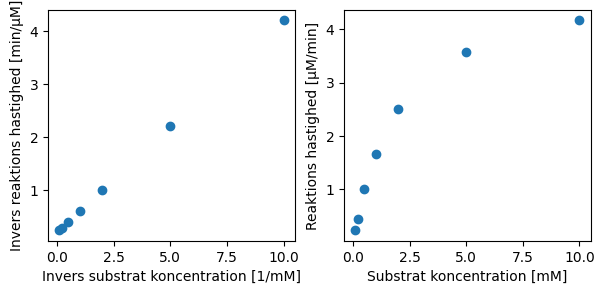

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
x_data = data['Inverse_Substrate'] # Bruger [...] til at hente kolonne
y_data = data['Inverse_Velocity'] 
axes[0].plot(x_data, y_data, 'o')
axes[1].plot(data['Substrate_Concentration'], data['Reaction_Velocity'], 'o')

axes[0].set_xlabel('Invers substrat koncentration [1/mM]')
axes[0].set_ylabel('Invers reaktions hastighed [min/μM]')
axes[1].set_xlabel('Substrat koncentration [mM]')
axes[1].set_ylabel('Reaktions hastighed [μM/min]')

Vi vil gerne finde ud af om det givne data opfører sig som vi forventer - sagt 
på en anden måde vil vi se om det passer med formlerne. 

Vi vil gøre dette ved at fitte dataen til ligningerne, dette er et *curve fit*. 
Python har mange redskaber der kan hjælpe os, i dette tilfælde vil vi bruge `curve_fit`-funktionen. 

For at bruge `curve_fit` skal vi fortælle programmet formlen for den funktion vi vil fitte mod. 
Det gøres ved at definere en funktion der beregner formlen. 


### Opgave 1: Fit af invers koncentration mod invers reaktionshastighed.

Til at starte med vil vi prøve at fitte en lineær funktion,

$$
y = a x + b
$$

Hvor

- $x$: Invers subtrat koncentratation.
- $y$: Invers reaktions hastighed.

Så vi vil altså finde hældningskoefficienten *a* og skæringspunktet *b* sådan at formlen 
passer bedst muligt til vores data.

Vi starter med at skrive en Python-funktion der definere den linære funktion

<div class="alert alert-block alert-info"> <b>Note:</b> At definere en funktion i Python er 
som skrive en opskrift ned uden at starte med at lave maden, 
der regnes ikke noget før funktionen 'kaldes' med () f.eks. <code>lineær_funktion(1, 2, 0)</code>.</div>

In [6]:
def lineær_funktion(x, a, b):
    """Lineær funktion for curve fitting.

    Parametre:
    x : Inverse substrat koncentration
    a : Hældningskoefficient
    b : Skæringspunkt med y-aksen

    Returnerer:
    Værdien af den lineære funktion for givet x.
    """
    return a * x + b # Opgave: Implementer formlen for den lineære funktion

Det er altid en god ide at checke at vi har implemeneret en funktion korrekt, 
i dette tilfælde kan vi f.eks. checke at disse gælder

- Hvis `x = 0` skal `lineær_funktion` give `b`.
- Hvis `x = 1` og `b = 0` skal `lineær_funktion` give `a`.

In [7]:
# Dette kalder funktionen så beregningen udføres
lineær_funktion(x=0, a=1, b=2) # For x = 0 skal funktionen returnere b

2

In [8]:
lineær_funktion(x=1, a=1, b=0) # For x = 1 og b = 0 skal funktionen returnere a

1

Nu har vi funktionen og kan nu bruge den til at fitte med. 

Vi starter med at trække de relevant kolonner ud af vores datasæt.

Den inverse substrat koncentration kan f.eks. trækkes ud med `data["Inverse_Substrate"]`

In [9]:
x_data = data['Inverse_Substrate'] # Opgave: Hent invers substrat koncentration
y_data = data['Inverse_Velocity']  # Opgave: Hent invers reaktions hastighed

Du kan printe dataen for at se at det er det korrekte

In [10]:
print(x_data)

0    10.0
1     5.0
2     2.0
3     1.0
4     0.5
5     0.2
6     0.1
Name: Inverse_Substrate, dtype: float64


Nu kan vi bruge `curve_fit` funktionen til at lave fittet. Syntaksen er 

`popt, pcov = curve_fit(funktion, x_data, y_data, p0)`

Hvor `popt` er en liste af de fundne parametre i samme rækkefølge som i definition af funktionen, og 
`p0` er et start gæt på hvad parametrene kunne være. 

I dette tilfælde vælger vi at gætte på at begge parametre er 1 så

In [11]:
p0 = (1, 1) # Opgave: Gæt på startværdier for a og b

In [12]:
popt, _ = curve_fit(lineær_funktion, x_data, y_data, p0=p0) # Opgave: Fit data til den lineære funktion
a, b = popt
print(f'Hældning: {a:.3f}') # Vi bruger 'print' til at udskrive værdier {a:.3f} betyder at vi udskriver a med 3 decimaler
print(f'Skæringspunkt: {b:.3f}') # Opgave: Udskriv hældning og skæringspunkt

Hældning: 0.400
Skæringspunkt: 0.200


<details>
    <summary><strong><span style="color: lightblue; font-size: 18px;">💡 Ekstra info</span></strong></summary>
    <p> curve_fit funktionen returnere en liste af de fundne parametre værdier, og variansen af dem. Ved at sige <code>popt, _</code> sættes variansen i en dummy variable <code>_</code> som vi ikke bruger.</p>
  </details>

Som vi har hørt i forelæsningen er dette  fit af reciprokke størrelser kendt som 
Lineweaver–Burk transformationen; 


\begin{align*}
y &= v  \\ 
&= a x + b \\ 
& = a [S] + b \\
& = \frac{K_m}{V_\mathrm{max}} [S] + \frac{1}{V_\mathrm{max}}
\end{align*}


Så kan vi bruge de fundne værdier af hældningen og skæringspunktet til at beregne $V_\mathrm{max}$ og $K_m$.
Det kan vises at

$$
V_{max} = \frac{1}{b}
$$

$$
K_m = \frac{a}{b}
$$

In [13]:
V_max = 1 / b # Opgave: Beregn V_max
K_m = a / b   # Opgave: Beregn K_m
print(f'V_max: {V_max:.3f} [μM/min]')
print(f'K_m: {K_m:.3f} [mM]')

V_max: 5.000 [μM/min]
K_m: 2.000 [mM]


<div class="alert alert-block alert-info"> <b>Note:</b> Det er altid vigtigt at holde styr på enheder af beregnede størrelser. Fra ligningen \(v = \frac{V_{\mathrm{max}}[S]}{K_m + [S]}\) kan vi se at enheden 
af \(K_m\) skal være \(mM\) og at \(V_{\mathrm{max}}\) har samme enhed som $v$ altså [μM/min].</div>

Vi kan nu bruge de fundne parametre til at udregne kurven fra vores fit.

In [14]:
x_fit = np.linspace(-1, 11, 100) # Dette laver 100 punkter mellem -1 og 11
y_fit = lineær_funktion(x_fit, a, b) # Vi bruger den lineære funktion til at beregne y-værdierne for de x-værdier vi har lavet

For at vurdere hvor godt vores fit passer kan vi beregne mean squared error (MSE)
fittet og vores data

$$
\mathrm{mse} = \frac{1}{N} \sum_i (f(x_i) - y_i)^2
$$
Hvor $f$ er den funktion vi har fittet, $N$ er antallet af data eksempler og $x_i$ og $y_i$ er vores data.
Figuren nedenfor illustrerer hvordan MSE kan fortolkes

<img src="https://images.prismic.io/encord/08ced892-f045-41f7-9007-d1ab3b426159_image7.png?auto=compress,format" width="600">

In [15]:
mse = np.sqrt(np.mean((lineær_funktion(x_data, a, b) - y_data) ** 2))
print(f'Mean Squared Error: {mse:.1e}')

Mean Squared Error: 3.4e-16


Du burde få en MSE sammenlignlig med `3.4e-16` som bettyder $3.4 \times 10^{-16}$, altså et meget lille tal.

Nu kan vi plotte vores fit sammen med dataen.

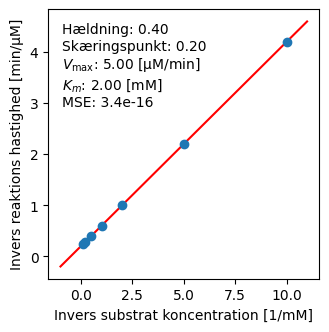

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Plot af den fitted lineære funktion
ax.plot(x_fit, y_fit, color='red') # Opgave: Plot den fittede funktion

# Plot af data -  dette plotter data som cirkler
ax.plot(data['Inverse_Substrate'], data['Inverse_Velocity'], 'o')

# Sætter en tekstboks med de fittede parametre ind
add_textbox(ax, a=a, b=b, V_max=V_max, K_m=K_m, mse=mse)

ax.set_xlabel('Invers substrat koncentration [1/mM]')
ax.set_ylabel('Invers reaktions hastighed [min/μM]');

<div class="alert alert-block alert-success"> <b>Takeaway:</b> Vi kan se at det  fit passer meget godt med vores data! Vi kan se det visuelt, linjen gør igennem alle vores data punkter og kvantativt har vi regnet en 
MSE på størrelses orden \(1 \times 10^{-16}\) (0.0000000000000001) som er på størrelse ordne af den numeriske 
præcision af Python brugt på denne måde.</div>

<details>
    <summary><strong><span style="color: lightblue; font-size: 18px;">💡 Ekstra info - Textbox </span></strong></summary>
    <p> Hvis du er interesseret kan du se koden for at lave tekstboxen med <code>add_textbox??</code> i en kode celle. 
    Dette kan gøres for alle funktioner som du gerne vil forstå i mere detalje. </p>
  </details>

### Opgave 2: Michaelis-Menten fit 

Nu vil vi fitte direkte til Michaelis-Menten ligningen, som igen er givet ved 

$$
v = \frac{V_{\mathrm{max}}[S]}{K_m + [S]}
$$

Vi skal altså finde parametrene $V_\mathrm{max}$ og $K_m$.

Vi starter med at definere en funktion der beregner formlen

In [17]:
def michaelis_menten(S, V_max, K_m):
    return (V_max * S) / (K_m + S) # Opgave: Implementer Michaelis-Menten ligningen

Et par ting der skal gælde for funktionen er; 

- For store værdier af koncentrationen `S` skal reaktions hastigheden være tæt på `V_max`
- Når koncentrationen er lig med Michaelis konstanten skal reaktionshastigheden være 1/2 `V_max`.

Brug denne information og de to næste celler til at analysere om din funktion er korrekt.

In [18]:
v = michaelis_menten(S=100, V_max=10, K_m=1)
print('S = 100, V_max = 10, K_m = 1')
print(f'v = {v:.2f}') # Skal være tæt på V_max

S = 100, V_max = 10, K_m = 1
v = 9.90


In [19]:
v = michaelis_menten(S=0.5, V_max=10, K_m=0.5)
print('S = 0.5, V_max = 10, K_m = 0.5')
print(f'v = {v:.2f}') # Skal være tæt på 1/2 V_max

S = 0.5, V_max = 10, K_m = 0.5
v = 5.00


Når du er tilfreds kan du gå videre til at lave fittet

Først skal vi hente den afhængige og uafhængige variable fra vores datasæt

In [20]:
x_data = data['Substrate_Concentration'] # Opgave: Hent substrat koncentration
y_data = data['Reaction_Velocity']  # Opgave: Hent reaktions hastighed

Nu har vi tre ting
- x: Den uafhængige variable
- y: Den afhængige variable
- En funktion 

Så vi mangler bare et start gæt på værdierne af $V_\mathrm{max}$ og $K_m$, som før vælger vi at sætte dem til 1.

In [21]:
p0 = (1, 1) # Start værider for V_max og Km

Nu er vi klar til at lave fittet. 

Brug i cellen nedenfor `curve_fit` og træk de to parametere ud i hver deres variable `V_max` og `K_m`.

<details>
    <summary><strong><span style="color: lightblue; font-size: 18px;">💡 Hint 1 </p></strong></summary>
    Husk at <code>curve_fit</code> returnere to ting en liste <code>popt</code> og <code>pcov</code> som vi ikke skal bruge.
  </details>

<details>
    <summary><strong><span style="color: lightblue; font-size: 18px;">💡 Hint 2 </p></strong></summary>
    Husk at du skal give 4 argumenter til <code>curve_fit</code> og at rækkefølgen skal være rigtig.    
  </details>

<details>
    <summary><strong><span style="color: lightblue; font-size: 18px;">💡 Hint 3 </p></strong></summary>
    Parameterne returneres <code></code> som en liste af tal i samme rækkefølge som de er brugt i funktionen <code>michaelis_menten</code>. Hvis du gemmer den i en variable <code>popt</code> kan du indeksere for at trække 
    hvert enkelt ud <code>V_max = popt[0]</code>
  </details>


In [22]:
(V_max, K_m), _ = curve_fit(michaelis_menten, x_data, y_data, p0=p0)

In [23]:
print(f'V_max: {V_max}')
print(f'K_m: {K_m}')

V_max: 5.0
K_m: 2.0


Ligesom med det linære fit kan vi nu regne funktionen med de fittede parametre og bruge 
disse til at udregne MSE og lavet et plot

In [24]:
x_fit = np.linspace(0, data['Substrate_Concentration'].max(), 100) # Laver 100 punkter mellem 0 og den maksimale substrat koncentration
y_fit = michaelis_menten(x_fit, V_max, K_m)

Vi regner MSE på samme måde, ved at sammenligne beregne funktions-værdier med data.

In [25]:
mse = np.sqrt(np.mean((michaelis_menten(x_data, V_max, K_m) - y_data) ** 2))
print(f'Mean Squared Error: {mse:.1e}')

Mean Squared Error: 3.8e-17


Og endeligt kan vi plotte vores fit

(-0.5, 10.5)

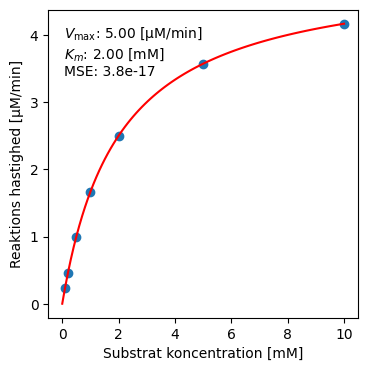

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(data['Substrate_Concentration'], data['Reaction_Velocity'], 'o')
ax.plot(x_fit, y_fit, label='Fitted Michaelis-Menten funktion', color='red')

add_textbox(ax, V_max=V_max, K_m=K_m, mse=mse)

ax.set_xlabel('Substrat koncentration [mM]')
ax.set_ylabel('Reaktions hastighed [μM/min]')
ax.set_xlim(0-0.5, x_fit.max()+0.5)

<div class="alert alert-block alert-success"> <b>Takeaway:</b> Vi får igen et rigtig godt fit med en meget lille MSE, 
og de fundne værdier af \(V_\mathrm{max}\) og \(K_m\) er de samme som vi fandt med det linære fit. </div>

# Opsamling

Vi har studeret Michaelis-Menten kinetik og lært at bruge Python til at fitte Michalis-Menten ligningen 
til et datasæt. 

Samme procedure kan bruges til at fitte andre former for ligninger til mange andre datasæt! 

Husk at skridtene til at fitte en ligning er

1. Definer en Python funktion for den ligninger der skal fittes med. 
2. Specifere det data der skal bruges, både `x` og `y`-værdier. 
3. Vælg et start gæt for de parametre der fittes `p0`.
3. Brug `curve_fit` til at få de fittede parametre. 

In [2]:
get_quiz()

<IPython.core.display.Javascript object>